In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from scipy.interpolate import UnivariateSpline
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import sys
import os
import pickle
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

np.set_printoptions(threshold=np.inf)

In [2]:
def get_time(quarter, clock):
    split_time = clock.split(':')
    return (quarter-1)*15 + int(split_time[0]) + int(split_time[1])/60

def get_distance_to_touchdown(yard_line, possession_team, field_position):
    if possession_team != field_position:
        return yard_line
    else:
        return 100 - yard_line

def get_time_since_snap(time_handoff, time_snap):
    split_handoff = time_handoff.split(':')
    handoff_sec = int(split_handoff[1])*60 + int(split_handoff[2].split('.')[0])
    split_snap = time_handoff.split(':')
    snap_sec = int(split_snap[1])*60 + int(split_snap[2].split('.')[0])
    return float(handoff_sec) - float(snap_sec)

def get_height(player_height):
    split_height = player_height.split('-')
    return int(split_height[0])*12 + int(split_height[1])

def get_age(player_birth_date):
    return 2019 - int(player_birth_date.split('/')[2])

def encode_personnel(personnel):
    PERSONNELS = ['DB', 'DL', 'LB', 'OL', 'QB', 'RB', 'TE', 'WR']
    encoded_personnel = [0]*len(PERSONNELS)
    personnel = personnel.replace(' ','')
    for i in range(0,len(personnel),4):
        encoded_personnel[PERSONNELS.index(personnel[i+1:i+3])] += int(personnel[i])
    return encoded_personnel

def get_offense_features(formation, personnel):
    FORMATIONS = ['SHOTGUN','SINGLEBACK','JUMBO','PISTOL','I_FORM','ACE','WILDCAT','EMPTY']
    one_hot_formation = [int(f == formation) for f in FORMATIONS]
    return one_hot_formation + encode_personnel(personnel)

def get_defense_features(in_the_box, personnel):
    return [in_the_box] + encode_personnel(personnel)

In [3]:
raw_data = pd.read_csv('data/train.csv')
raw_data['Temperature'] = raw_data['Temperature'].fillna(raw_data['Temperature'].mean())
raw_data['Humidity'] = raw_data['Humidity'].fillna(raw_data['Humidity'].mean())
raw_data = raw_data.dropna()
plays = np.unique(raw_data['PlayId'])
plays_trn, plays_val_tst = train_test_split(plays, train_size=0.5)
plays_val, plays_tst = train_test_split(plays_val_tst, train_size=0.5)
trn_data = raw_data[raw_data['PlayId'].isin(plays_trn)]
val_data = raw_data[raw_data['PlayId'].isin(plays_val)]
tst_data = raw_data[raw_data['PlayId'].isin(plays_tst)]

In [4]:
trn_input = []
trn_target = []
val_input = []
val_target = []
tst_input = []
tst_target = []

In [ ]:
for _data, _input, _target in zip([trn_data, val_data, tst_data], [trn_input, val_input, tst_input], [trn_target, val_target, tst_target]):
    for _,play in _data.groupby(['PlayId']):
        state_features = []
        state_features.append(get_distance_to_touchdown(play['YardLine'].iloc[0], play['PossessionTeam'].iloc[0], play['FieldPosition'].iloc[0]))
        state_features.append(get_time(play['Quarter'].iloc[0],play['GameClock'].iloc[0]))
        state_features.append(play['Down'].iloc[0])
        state_features.append(play['Distance'].iloc[0])
        state_features.append(get_time_since_snap(play['TimeHandoff'].iloc[0], play['TimeSnap'].iloc[0]))
        state_features.append(play['Temperature'].iloc[0])
        state_features.append(play['Humidity'].iloc[0])
        
        offense_features = get_offense_features(play['OffenseFormation'].iloc[0], play['OffensePersonnel'].iloc[0])
        
        defense_features = get_defense_features(play['DefendersInTheBox'].iloc[0], play['DefensePersonnel'].iloc[0])    
        
        runner = play.loc[play['NflId'] == play['NflIdRusher']]
        px = runner['X']
        py = runner['Y']
        ox = np.sin(np.deg2rad(runner['Orientation']))
        oy = np.cos(np.deg2rad(runner['Orientation']))
        vx = runner['S'] * np.sin(np.deg2rad(runner['Dir']))
        vy = runner['S'] * np.cos(np.deg2rad(runner['Dir']))
        ax = runner['A'] * np.sin(np.deg2rad(runner['Dir']))
        ay = runner['A'] * np.cos(np.deg2rad(runner['Dir']))
        if play['PlayDirection'].iloc[0] != 'right':
            px *= -1
            ox *= -1
            vx *= -1
            ax *= -1
        h = get_height(runner['PlayerHeight'].iloc[0])
        w = runner['PlayerWeight'].iloc[0]
        a = get_age(runner['PlayerBirthDate'].iloc[0])
        runner_features = [i.values[0] for i in [px,py,ox,oy,vx,vy,ax,ay]] + [h,w,a]
        _input.append(state_features + offense_features + defense_features + runner_features)
        _target.append(play['Yards'].iloc[0])

In [ ]:
with open('data/data.pkl', 'wb') as f:
    pickle.dump([trn_input, val_input, tst_input, trn_target, val_target, tst_target], f)

In [5]:
with open('data/data.pkl', 'rb') as f:
    trn_input, val_input, tst_input, trn_target, val_target, tst_target = pickle.load(f)

In [6]:
trn_input = np.stack(trn_input)
trn_target = np.array(trn_target)
val_input = np.stack(val_input)
val_target = np.stack(val_target)

In [41]:
pmse = np.zeros((3,2,11))
naive_mse = np.mean((val_target - np.mean(trn_target)) * (val_target - np.mean(trn_target)))

methods = [LinearRegression(), RidgeCV(), LassoCV()]
degrees = [1,2]
comps = [0,1,2,3,4,5,6,7,8,9,10]
for i,method in enumerate(methods):
    for j,degree in enumerate(degrees):
        for k,comp in enumerate(comps):
            model = make_pipeline(PolynomialFeatures(degree), method)
            mse = None
            if comp != 0:
                pca = PCA(comp)
                model.fit(pca.fit_transform(trn_input), trn_target)
                mse = mean_squared_error(val_target, model.predict(pca.transform(val_input)))
            else:
                model.fit(trn_input, trn_target)
                mse = mean_squared_error(val_target, model.predict(val_input))
            pmse[i,j,k] = (naive_mse - mse) / naive_mse * 100

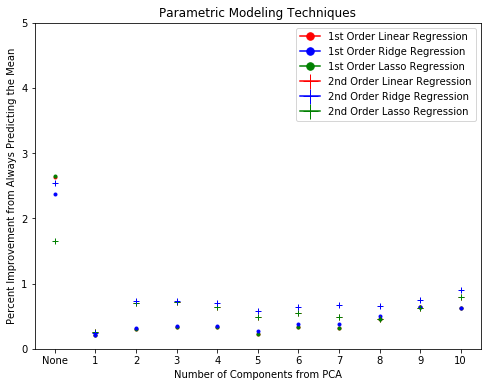

In [53]:
plt.figure(figsize=(8,6))
plt.plot(range(11),pmse[0,0,:].flatten(),'r.',
         range(11),pmse[1,0,:].flatten(),'g.',
         range(11),pmse[2,0,:].flatten(),'b.',
         range(11),pmse[0,1,:].flatten(),'r+',
         range(11),pmse[1,1,:].flatten(),'g+',
         range(11),pmse[2,1,:].flatten(),'b+')
rd = mlines.Line2D([], [], color='red', marker='.',markersize=15, label='1st Order Linear Regression')
bd = mlines.Line2D([], [], color='blue', marker='.',markersize=15, label='1st Order Ridge Regression')
gd = mlines.Line2D([], [], color='green', marker='.',markersize=15, label='1st Order Lasso Regression')
rp = mlines.Line2D([], [], color='red', marker='+',markersize=15, label='2nd Order Linear Regression')
bp = mlines.Line2D([], [], color='blue', marker='+',markersize=15, label='2nd Order Ridge Regression')
gp = mlines.Line2D([], [], color='green', marker='+',markersize=15, label='2nd Order Lasso Regression')
plt.legend(handles=[rd,bd,gd,rp,bp,gp])
plt.xlabel('Number of Components from PCA')
plt.xticks(np.arange(11), ('None','1','2','3','4','5','6','7','8','9','10'))
plt.ylim(0,5)
plt.ylabel('Percent Improvement from Always Predicting the Mean')
plt.title('Parametric Modeling Techniques')
plt.savefig('parametric_models.png')
plt.show()

In [51]:
np.amax(pmse)
print(pmse[0,0,0])

2.636026147586832


In [21]:
for k in range(1,500,5):
    model = KNeighborsRegressor(500)
    model.fit(trn_input,trn_target)
    print(mean_squared_error(val_target, model.predict(val_input)))

75.51237739374125
51.44842103897452
48.51415689741026
47.59586915430874
47.32071075355255
46.776017124111114
46.52365952677545
46.39557384918782
46.23870269164864
46.256931795205496
46.16566132272986
46.23488280617011
46.190223482585736
46.103748141257164
46.09566324935159
46.078377073842574
46.02098002285312
46.018364541318896
45.95349770872147
45.92711635167724
45.86277679913514
45.86785340341123
45.870813041350935
45.895263702382735
45.861055714852704
45.85712152766378
45.82999073722798
45.87905739292104
45.87619334808575
45.895742193118316
45.879521496441164
45.89461239517379
45.88261646005528
45.85376052021008
45.849099506954566
45.839366244219505
45.87136847518697
45.8668776737195
45.87437822335931
45.891906513341695
45.88933889069874
45.90083702824913
45.90252414457107
45.902698971481726
45.91538505241837
45.918551629283456
45.92249460661175
45.91494564608488
45.88917932027492
45.86531388211776
45.85410985706721
45.84550763290099
45.85380185000779
45.85787535452504
45.8623600482